In [1]:
using LinearAlgebra, Plots, ForwardDiff

┌ Info: Recompiling stale cache file /Users/semihakbayrak/.julia/compiled/v1.2/Plots/ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


We are interested in maximizing or minimizing a function $f:\mathbb{R}^n \rightarrow \mathbb{R}$ without any constrained defined on the input $\mathbf{x}$.

Note that by Taylor series expansion around a local optimum point $\mathbf{x}^*$, we can approximate the function as
$$
f(\mathbf{x}) \approx f(\mathbf{x}^*) + \nabla f(\mathbf{x}^*)\cdot(\mathbf{x}-\mathbf{x}^*) + \frac{1}{2} (\mathbf{x}-\mathbf{x}^*)^T \cdot H_f (\mathbf{x}-\mathbf{x}^*)
$$
where $H_f$ is the jacobian of $f$ evaluated at $\mathbf{x}^*$. Since $\mathbf{x}^*$ is an optimum point, $\nabla f(\mathbf{x}^*)$ is zero and the above equation reduces to
$$
f(\mathbf{x}) \approx f(\mathbf{x}^*) + \frac{1}{2} (\mathbf{x}-\mathbf{x}^*)^T \cdot H_f (\mathbf{x}-\mathbf{x}^*)
$$
Now, if we set $\mathbf{x}$ to $\mathbf{x}^* + \Delta\mathbf{x}$, $f(\mathbf{x}+ \Delta\mathbf{x})$ becomes larger than $f(\mathbf{x}^*)$ for positive definite $H_f$ and smaller for negative definite $H_f$. Therefore we can define the following rules

- $\mathbf{x}^*$ is local minimum if $H_f$ is positive definite (all eigenvalues > 0).

- $\mathbf{x}^*$ is local maximum if $H_f$ is negative definite (all eigenvalues < 0).

- $\mathbf{x}^*$ is saddle point if $H_f$ is indefinite (at least one eigenvalue > 0 and at least one eigenvalue < 0).

- If $H_f$ is not invertable (semi-definite). Then we encounter an odd case.

__Definition:__ A function $f:\mathbb{R}^n \rightarrow \mathbb{R}$ is convex iff $f(a \cdot \mathbf{x} + (1-a) \cdot \mathbf{y})\leq a \cdot f(\mathbf{x}) + (1-a) \cdot f(\mathbf{y})$ for $a \in (0,1)$. It is strictly convex iff we can replace $\leq$ with $<$.

__Preposition:__ A local minimum of a convex function $f:\mathbb{R}^n \rightarrow \mathbb{R}$ is necessarily a global minimum.

# One-Dimensional Strategies

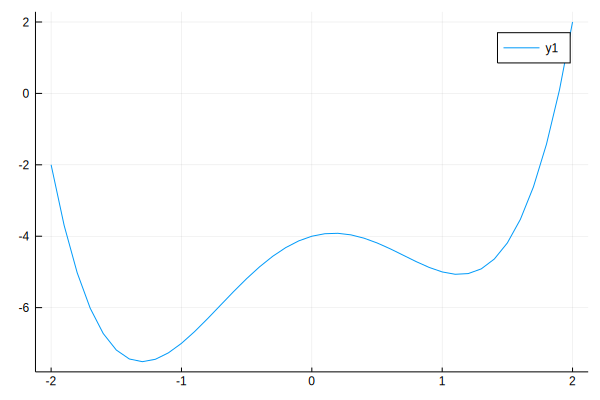

In [16]:
f(x) = x^4 - 3*x^2 + x - 4 #non-convex function example
x_vals = collect(-2:0.1:2)
f_vals = f.(x_vals)
plot(x_vals,f_vals)

## Newton's Method

$f(x_k+\Delta) \approx f(x_k) + \Delta f^{'}(x_k) + \frac{1}{2} \Delta^2f^{''}(x_k)$

$\frac{d}{d\Delta}f(x_k+\Delta)=0$ => $f^{'}(x_k) + \Delta f^{''}(x_k) = 0$ => $x_{k+1} = x_k - \frac{f^{'}(x_k)}{f^{''}(x_k)}$

Above formula refers to root finding for the derivative of $f$. In case function is quadratic, Newton's method find the optimum at one step.

In [20]:
function Newton(f,x_init,eps)
    df(x) = ForwardDiff.derivative(f,x)
    ddf(x) = ForwardDiff.derivative(df,x)
    x = x_init
    x_old = x
    cond = false
    while cond == false
        x = x - df(x)/ddf(x)
        if abs(x-x_old)<eps
            cond = true
        else
            x_old = x
        end
    end
    status = "a minima"
    if ddf(x)<0
        status = "a maxima"
    end
    return x, status
end

Newton (generic function with 1 method)

In [22]:
g(x) = (x-4.2)^2 + 5;

In [23]:
Newton(g,-2,0.001)

(4.2, "a minima")

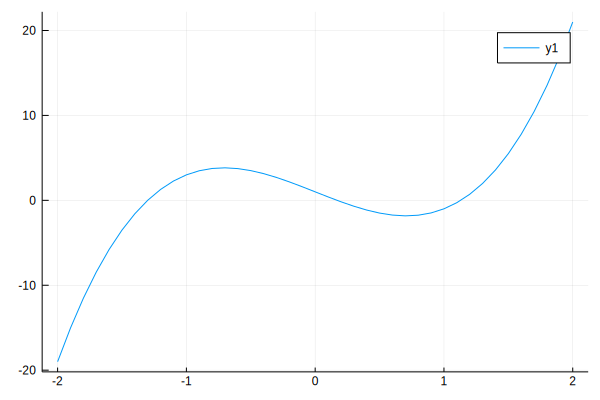

In [27]:
df(x) = ForwardDiff.derivative(f,x)
x_vals = collect(-2:0.1:2)
df_vals = df.(x_vals)
plot(x_vals,df_vals)

In [24]:
Newton(f,-2,0.001)

(-1.3008395659742267, "a minima")

In [25]:
Newton(f,-1,0.001)

(-1.300839565943423, "a minima")

In [26]:
Newton(f,-0.1,0.001)

(0.16993844331135663, "a maxima")

In [28]:
Newton(f,0.5,0.001)

(0.16993844330637503, "a maxima")

In [29]:
Newton(f,0.7,0.001)

(-1.3008395667905284, "a minima")

In [30]:
Newton(f,0.9,0.001)

(1.1309011226360324, "a minima")

In [31]:
Newton(f,1.2,0.001)

(1.1309011264327247, "a minima")

In [32]:
Newton(f,2.7,0.001)

(1.1309011439707095, "a minima")

Notice that the optima Newton's method converges havily depends on the initial point.

## Golden Section Search

A decent alternative for non-differentiable $f$.

# Multivariable Strategies

In [80]:
f(x) = x'*(x.^3 .- 1.5) - 3*x'*x + 4

f (generic function with 2 methods)

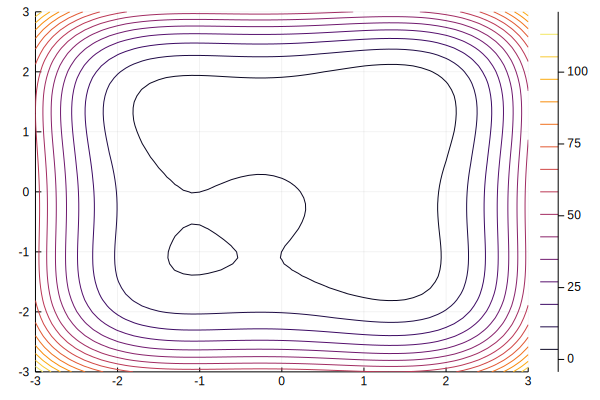

In [81]:
x = -3:0.1:3
y = -3:0.1:3
f(a, b) = begin
        x = [a,b]
        x'*(x.^3 .- 1.5) - 3*x'*x + 4
        #x'*([x[1]^3,abs(x[2])^2] .- 1.5) - 2*x'*x + 4
    end
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(y, 1, length(x))
Z = map(f, X, Y)
p2 = contour(x, y, Z)
plot(p2)

# Gradient Descent

$\mathbf{x}_{k+1} = \mathbf{x}_{k+1} - \eta \nabla f(\mathbf{x}_{k})$

In [82]:
#without line search
function GradientDescent(f,x_init,eps,step_size)
    df(x) = ForwardDiff.gradient(f,x)
    x = x_init
    x_old = x
    cond = false
    while cond == false
        x = x - step_size .* df(x)
        if sum(abs.(x-x_old))<eps
            cond = true
        else
            x_old = x
        end
    end
    return x
end

GradientDescent (generic function with 1 method)

In [87]:
GradientDescent(f,[-2,-3],0.00001,0.001)

2-element Array{Float64,1}:
 -1.0731267288543154
 -1.0732364559586636

In [88]:
GradientDescent(f,[4,4],0.00001,0.001)

2-element Array{Float64,1}:
 1.3348580221193111
 1.3348580221193111

# Newton's Method

$\mathbf{x}_{k+1} = \mathbf{x}_{k+1} - [H_f(\mathbf{x}_{k})]^{-1} \nabla f(\mathbf{x}_{k})$

If $H_f(\mathbf{x}_{k})$ is nearly singular, step sizes become very large to converge. One way to address this issue is to use small step sizes:

$\mathbf{x}_{k+1} = \mathbf{x}_{k+1} - \eta[H_f(\mathbf{x}_{k})]^{-1} \nabla f(\mathbf{x}_{k})$

In order for Newton's method to converge to a local minima, Hessian must be positive definite. A hybrid approach would be to check positive definiteness of the Hessian at each time step and go with Newton's method if this condition is satisfied, otherwise we can use gradient descent.

In [92]:
function NewtonM(f,x_init,eps)
    df(x) = ForwardDiff.gradient(f,x)
    ddf(x) = ForwardDiff.jacobian(df,x)
    x = x_init
    x_old = x
    cond = false
    while cond == false
        x = x - inv(ddf(x))*df(x)
        if sum(abs.(x-x_old))<eps
            cond = true
        else
            x_old = x
        end
    end
    return x
end

NewtonM (generic function with 1 method)

In [93]:
NewtonM(f,[-2,-3],0.00001)

2-element Array{Float64,1}:
 -1.0725513456002111
 -1.072551345623567 

In [94]:
NewtonM(f,[4,4],0.00001)

2-element Array{Float64,1}:
 1.334539544144846
 1.334539544144846

# BFGS

BFGS is a quasi-Newton method that avoids exact calculation of the Hessian, which can be costly in certain applications. Instead, it provides an iterative Hessian estimation procedure which converges while the function is minimized.